In this notebook, the approach to create output video is different. Instead of creating video as soon as the inference is done, the individual frames (after inference) are sved in a folder and later combined into a video. 

### This notebook was run for model Faster R-CNN Inception ResNet V2 1024x1024 

Importing required modules

In [1]:
import os
import pathlib

import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from six.moves.urllib.request import urlopen

import tensorflow as tf
import tensorflow_hub as hub

import cv2
from more_itertools import chunked

tf.get_logger().setLevel('ERROR')

### Importing data - video

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Montreal_street_HW4.mp4 to Montreal_street_HW4.mp4


### Utilities for Object detection

1) A dictionary of pre-trained object detection models on TF Hub 

(given as {model name: model link})

In [3]:
ALL_MODELS = {
'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
}

### Visualizing tool - TensorFlow Object detection API 

The images with the bounding box or mask can be visualized using this tool. A github repository is cloned to install this API.  

In [4]:
# Cloning the required tensor flow repository
!git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3691, done.
remote: Counting objects: 100% (3691/3691), done.
remote: Compressing objects: 100% (3079/3079), done.
remote: Total 3691 (delta 990), reused 1510 (delta 561), pack-reused 0
Receiving objects: 100% (3691/3691), 48.75 MiB | 25.96 MiB/s, done.
Resolving deltas: 100% (990/990), done.


In [5]:
## installing the API

%%bash
sudo apt install -y protobuf-compiler
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Reading package lists...
Building dependency tree...
Reading state information...
protobuf-compiler is already the newest version (3.6.1.3-2ubuntu5).
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.9/26.9 MB 34.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 KB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1

In [6]:
### importing required modules from above installed API

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import ops as utils_ops

%matplotlib inline

### Label mapping data

The CNN predicts numbers/ indexes. From the same repository as above, the labels corresponding to the number/ index is loaded. This will help tagging the objects, in the images, with labels than a numbers. 

In [7]:
labels_path = './models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(labels_path, use_display_name=True)

### Selecting the pre-trained Model

The list of models are from dictionary of pre-trained models given above. 

Select one from the drop down. 

In [8]:
model_display_name = 'Faster R-CNN Inception ResNet V2 1024x1024' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
model_handle = ALL_MODELS[model_display_name]

print('Selected model:'+ model_display_name)
print('Model Handle at TensorFlow Hub: {}'.format(model_handle))

Selected model:Faster R-CNN Inception ResNet V2 1024x1024
Model Handle at TensorFlow Hub: https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1


### Loading the selected model 

The model is loaded from TensorFlow Hub. 

In [9]:
TFhub_model = hub.load(model_handle)
print('Model loaded!')

Model loaded!


**Splitting video into image frames & performing object dectection with selected model**

The input video will be split into 2 frames per sec. Object detetcion (Inference) is perfomed using pretrained models on these individual frames. The output is saved as a video with these bounding boxes around objects in the video.   

In [10]:
capture = cv2.VideoCapture('Montreal_street_HW4.mp4')    ## a variable to hold video data

n_frames = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))            ## total number of frames in the video
fps    = capture.get(cv2.CAP_PROP_FPS)             ## number of frames per second

_, img = capture.read()                                  ## reads first image/frame of video and returns numpy array of image 
img_height, img_width, layers = img.shape                ## finding shape of the frame/image

print(f'There are totally {n_frames} frames in this video and {fps} frames per second')
print(f'Each frame/image height, width and layer is {img_height} x {img_width} x {layers}')

There are totally 267 frames in this video and 30.0 frames per second
Each frame/image height, width and layer is 1080 x 1920 x 3


Visualizing first frame of video

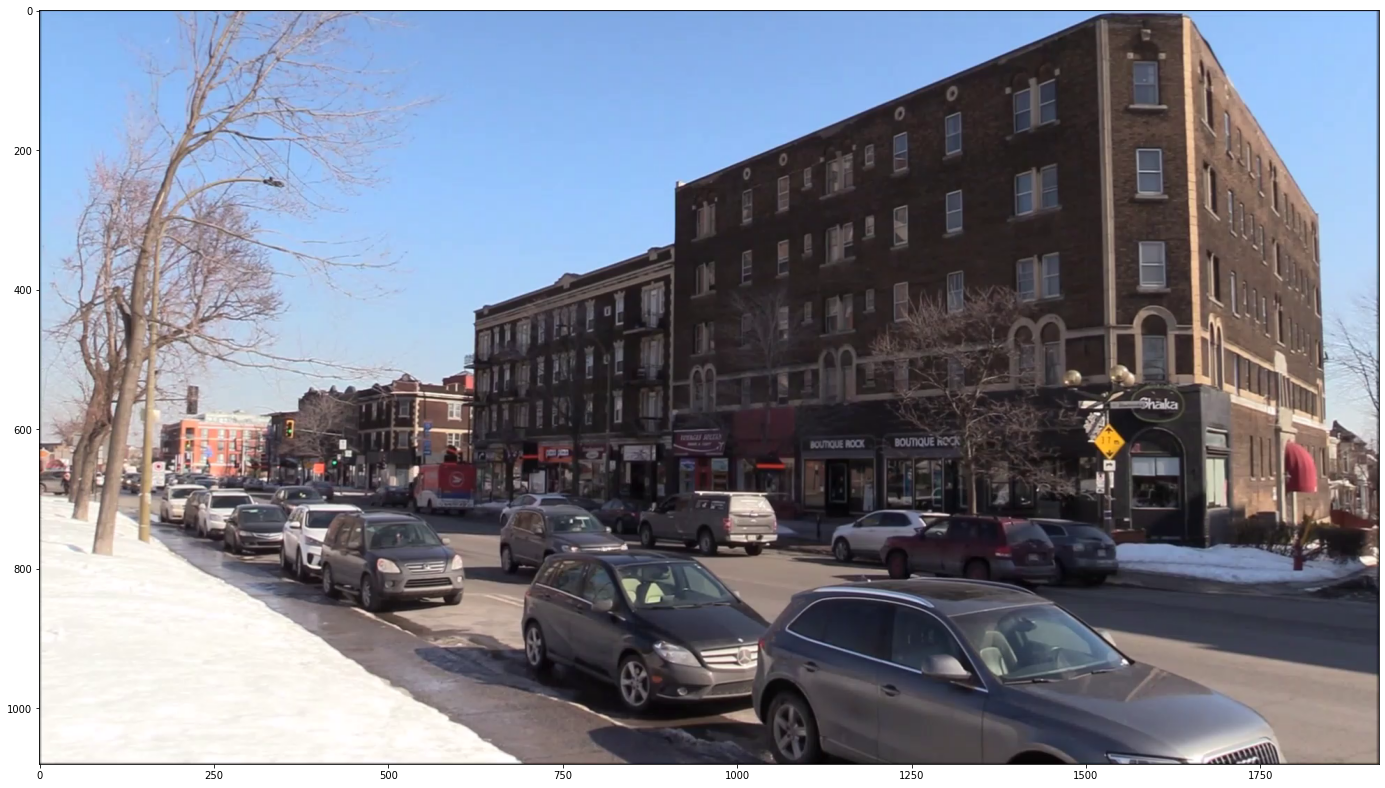

In [11]:
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     ## OpenCV uses BGR color order by default, thus converting to RGB
plt.figure(figsize=(24,32))
plt.imshow(img_RGB)
plt.show()

Performing object detection on first frame of video only and visulaizing the same

In [12]:
img_reshaped = img_RGB.reshape((1, img_height, img_width, layers)).astype(np.uint8)  ## reshaping numpy array of image as per model requirement 
results = TFhub_model(img_reshaped)    ## running inference 
result = {key:value.numpy() for key,value in results.items()}
result.keys()

dict_keys(['raw_detection_scores', 'raw_detection_boxes', 'num_detections', 'detection_classes', 'detection_boxes', 'detection_anchor_indices', 'detection_multiclass_scores', 'detection_scores'])

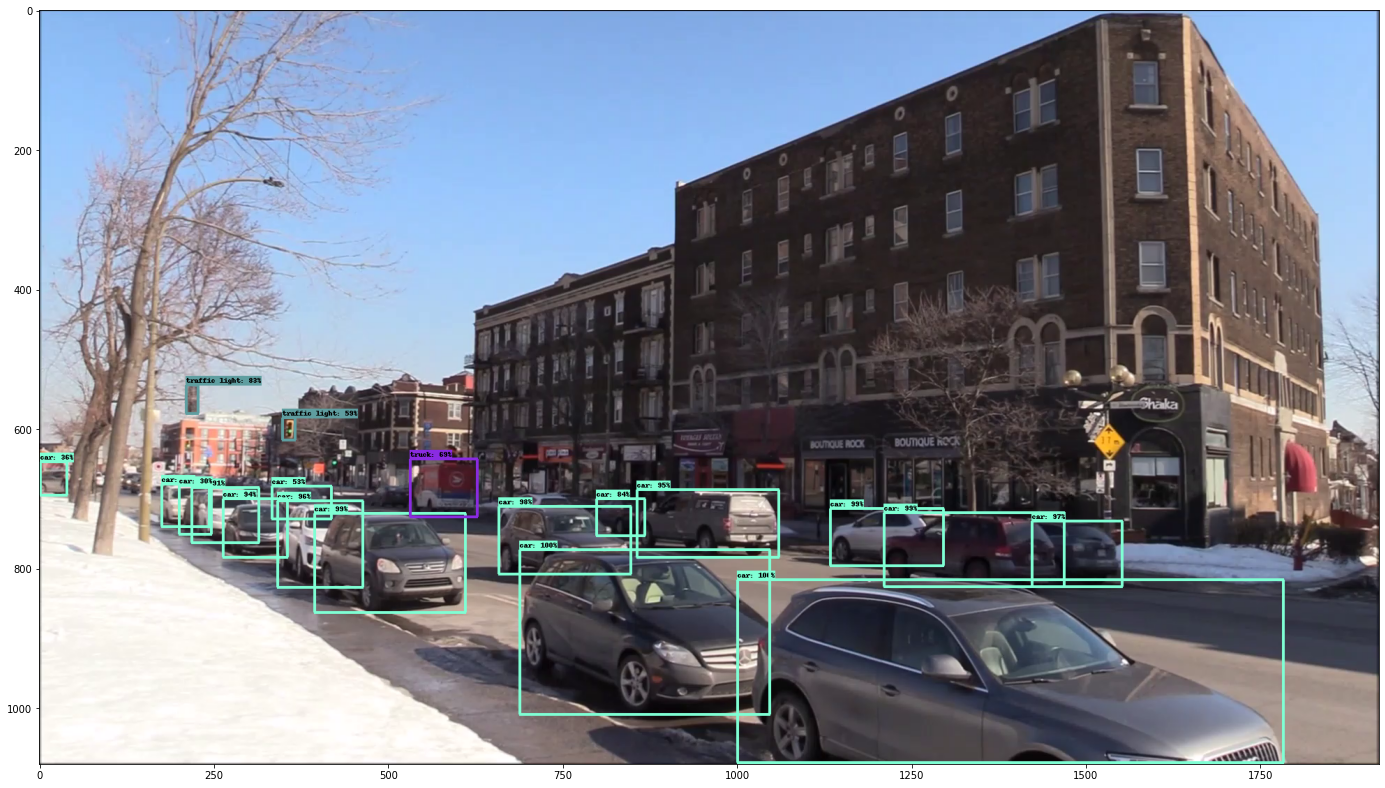

In [13]:
label_id_offset = 0
image_np_with_detections = img_reshaped.copy()

# # Use keypoints if available in detections
keypoints, keypoint_scores = None, None
# if 'detection_keypoints' in result:
#   keypoints = result['detection_keypoints'][0]
#   keypoint_scores = result['detection_keypoint_scores'][0]

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores)
      # keypoint_edges=COCO17_HUMAN_POSE_KEYPOINTS)

plt.figure(figsize=(24,32))
plt.imshow(image_np_with_detections[0])
plt.show()

Performing object detection on all frames of video and combining these frames back to a video 

In [14]:
capture = cv2.VideoCapture('Montreal_street_HW4.mp4')    ## a variable to hold video data

## performing inference on all frames in video
print(f'Total Frames present in video = {n_frames}')

images = []

while (capture.isOpened()):
  _, img = capture.read()     ## getting frames from video
  if _ is False:
    break
  else:
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     ## converting BGR to RGB image
    img_reshaped = img_RGB.reshape((1, img_height, img_width, layers)).astype(np.uint8)  ## reshaping numpy array of image as per model requirement 
    images.append(img_reshaped)
  

capture.release()   ## closing the video
print(f'Total images extracted = {len(images)}')

Total Frames present in video = 267
Total images extracted = 267


In [15]:
print('Created batches of 20 images....')

img_batches = list(chunked(images, 20))

print(f'{len(img_batches)} batches created')

Created batches of 20 images....
14 batches created


In [16]:
### Creating directory for inferred images (frames of video with bounding box)

os.makedirs('inferred_frames')

In [17]:
for i in range(len(img_batches)):
  print(f' Processing Batch {i+1}')
  for j in range(len(img_batches[i])):
    print(f'Processing Image {j+1}')
    results = TFhub_model(img_batches[i][j])    ## running inference 
    result = {key:value.numpy() for key,value in results.items()}    ## dictionary of outputs
    
    label_id_offset = 0
    image_np_with_detections = img_batches[i][j].copy()
    
    keypoints, keypoint_scores = None, None                # Use keypoints if available in detections
    # if 'detection_keypoints' in result:
    #   keypoints = result['detection_keypoints'][0]
    #   keypoint_scores = result['detection_keypoint_scores'][0]
    
    viz_utils.visualize_boxes_and_labels_on_image_array(         ### image (frame) tagged with bounding boxes
      image_np_with_detections[0],
      result['detection_boxes'][0],
      (result['detection_classes'][0] + label_id_offset).astype(int),
      result['detection_scores'][0],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False,
      keypoints=keypoints,
      keypoint_scores=keypoint_scores)
    
    frame_RGB = cv2.cvtColor(image_np_with_detections[0], cv2.COLOR_BGR2RGB)
    cv2.imwrite(f'./inferred_frames/BBframe_{i+1}_{j+1}.jpg', frame_RGB)

 Processing Batch 1
Processing Image 1
Processing Image 2
Processing Image 3
Processing Image 4
Processing Image 5
Processing Image 6
Processing Image 7
Processing Image 8
Processing Image 9
Processing Image 10
Processing Image 11
Processing Image 12
Processing Image 13
Processing Image 14
Processing Image 15
Processing Image 16
Processing Image 17
Processing Image 18
Processing Image 19
Processing Image 20
 Processing Batch 2
Processing Image 1
Processing Image 2
Processing Image 3
Processing Image 4
Processing Image 5
Processing Image 6
Processing Image 7
Processing Image 8
Processing Image 9
Processing Image 10
Processing Image 11
Processing Image 12
Processing Image 13
Processing Image 14
Processing Image 15
Processing Image 16
Processing Image 17
Processing Image 18
Processing Image 19
Processing Image 20
 Processing Batch 3
Processing Image 1
Processing Image 2
Processing Image 3
Processing Image 4
Processing Image 5
Processing Image 6
Processing Image 7
Processing Image 8
Proces

In [30]:
## output video details
fourcc = cv2.VideoWriter_fourcc(*'mp4v')     ## defining output video data type
output_video = cv2.VideoWriter('output_HW4_Faster_R-CNN.mp4', fourcc, fps, (img_width, img_height))  ## giving output video name

In [31]:
## creating video by combining frames 

inferred_imgs = sorted([image for image in os.listdir('inferred_frames') if image.endswith('.jpg')], 
                       key=lambda x: (int(x.split('_')[1]), int(x.split('_')[2].split('.')[0].zfill(2))))

for img in inferred_imgs:
   output_video.write(cv2.imread(os.path.join('inferred_frames', img)))


### closing all windows that are open
cv2.destroyAllWindows()
output_video.release()

### The output video, with the bounding boxes, is saved in the current directory when runing the code. 
### The output video is also attached in the folder provided with this notebook.  